In [6]:
# EXPLORE DATA
import os
import numpy as np
import librosa
import random
import pandas as pd

# DATA PROCESSING
DATASET_PATH = "/home/gmallet/datasets/gtzan"
ROI_PATH = DATASET_PATH + "/genres_original/"

# TODO MAKE DCA USING THIS
df = pd.read_csv(os.path.join(DATASET_PATH, "features_3_sec.csv"))
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [7]:
TIME_SERIES_LENGTH = 128
HOP_LENGTH = 512
CATEGORIES = os.listdir(ROI_PATH)

# AUDIO SAMPLING RATE
sr = 22050
SONG_DURATION = 29
# TOTAL NB SAMPLE OF EACH SONG
TOTAL_SAMPLES = SONG_DURATION * sr
# NB SLICE PER SONG
NB_SLICES = 10
# HOW MANY SAMPLE IS NEEDED TO MAKE A SLICE
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NB_SLICES)

def get_files(root_path, extension):
    files_paths = []
    for root, _, files in os.walk(root_path, topdown=True):
        files_paths += [os.path.join(root, file) for file in files if file.endswith(extension)]
    return files_paths

# USE ALL POSSIBLE SAMPLE PER SONG
# DECIDED TO GO WITH MFCC TO EXTRACT FEATURES FROM SONG.
# THE FIRST REASON I CHOOSE MFCC IS BECAUSE OF HIS POPULARITY, PRETTY MUCH EVERY AUDIO
# CLASSIFICATION USE IT. THE SECOND IS BY FINDING HOW MFCC GLOBALLY WORKS, BY SCALING FREQUENCIES
# TO MEL SCALE, WHICH 'SIMULATE' THE WAY HUMAN EARS WORKS USING A LOG SCALE SINCE FOR A HUMAN,
# THE DIFFERENCE BTW 1KhZ and 2KhZ THAN BTW 4KhZ AND 5KhZ. THE MOST IMPORTANT FOR HUMAN EARS IS THE RATE OF
# CHANGE, NOT THE ABSOLUTE DIFFERENCE BTW 2 FREQUENCIES.
def extract_audio_features(files_paths):
    labels = []
    features = []
    for i, file_path in enumerate(files_paths):
        song, sr = librosa.load(file_path, duration=SONG_DURATION)
        genre = file_path.split("/")[-2]
        index = CATEGORIES.index(genre)
        for s in range(NB_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            labels.append(index)
            features.append(mfcc.tolist())
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, len(files_paths)), end=''
        )
    print()
    return (np.array(features), np.array(labels))


# USE ONLY ONE SAMPLE PER SONG, AND STILL MFCC ON THE WHOLE SONG SO REALLY BAD
def bad_extract_audio_features(files_paths):
    nb_files = len(files_paths)
    
    features = np.zeros(
        (nb_files, TIME_SERIES_LENGTH, 13), dtype=np.float64
    )
    
    
    labels = np.zeros(
        (nb_files, 1), dtype=np.int32
     )
    
    for i, file in enumerate(files_paths):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=HOP_LENGTH, n_mfcc=13
        )
            
        genre = file.split("/")[-2]
        index = CATEGORIES.index(genre)
        
        labels[i][0] = index 
        features[i, :] = mfcc.T[0:TIME_SERIES_LENGTH, :]
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, nb_files), end=''
        )
    print()
    return (features, labels)



def load_data(files_path):
    files_paths = get_files(files_path, "wav")
    random.shuffle(files_paths)
    a, b = int(len(files_paths) * 0.8), int(len(files_paths) * 0.9)
    train_fp, val_fp, test_fp = files_paths[:a], files_paths[a:b], files_paths[b:]

    # SHOULD SAVE THIS TO JSON OR SMTHG
    return {
        "train": extract_audio_features(train_fp),
        "validate": extract_audio_features(val_fp),
        "test": extract_audio_features(test_fp),
    }

dataset = load_data(ROI_PATH)

Extracted features audio track 799 of 799.
Extracted features audio track 100 of 100.
Extracted features audio track 100 of 100.


In [8]:
# MODEL
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, TimeDistributed
from keras.losses import SparseCategoricalCrossentropy

# FIRST INTUITION THOUGH MUSIC IS SORT OF A TIME SERIES, AND RNNs ARE SUPPOSED TO BE MADE FOR THIS.
# EVEN THO SAW A LOT OF CNN PERFORM A LOT BETTER THAN EVERY RNN ON THIS DATASET, DON'T HAVE MUCH EXPLANATION HERE,
# STILL DECIDED TO WORK WITH RNN SINCE NEVER DONE ANY.
# BIT OF SEARCH ON THE SUBJET THAUGH ME THAT RNNs WHEREN'T THE WAY TO GO UNLESS YOU REALLY KNOW WHAT YOUR DOING,
# BECAUSE OF VANISHING GRADIENT PROBLEM, SO DECIDED TO GO FOR LSTM.
def get_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
    # TRY WITH TimeDistributed LAYERS
    model.add(Dense(units=output_size, activation="softmax"))

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [9]:
# TRAINING
# I DON'T HAVE MUCH TO SAY ON THESE 2 PARAMETERS, TRYED DIFFERENTS ONE RANDOMLY, THESE WERE WORKING WELL, 
# EVEN THOUGH BATCH_SIZE IS MAYBE A BIT TOO BIG, SO TRAINING TAKE A LOT OF TIME.
BATCH_SIZE = 60
NUM_EPOCHS = 40

def train(dataset):
    input_shape = (dataset["test"][0].shape[1], dataset["test"][0].shape[2])
    model = get_model(input_shape, 10)
    return model, model.fit(
        dataset["train"][0],
        dataset["train"][1],
        validation_data=dataset["validate"],
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        shuffle=True
    )

In [10]:
# VISUALIZATION
import matplotlib.pyplot as plt

def show_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(NUM_EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [11]:
model, history = train(dataset)

2022-03-31 21:02:38.398302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 21:02:38.398327: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 21:02:38.398341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (station): /proc/driver/nvidia/version does not exist
2022-03-31 21:02:38.398643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


/home/gmallet/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


134/134 [==============================] - 34s 226ms/step - loss: 1.7522 - accuracy: 0.3736 - val_loss: 1.4546 - val_accuracy: 0.4980
Epoch 2/40
134/134 [==============================] - 30s 226ms/step - loss: 1.4140 - accuracy: 0.4902 - val_loss: 1.4618 - val_accuracy: 0.4880
Epoch 3/40
134/134 [==============================] - 30s 227ms/step - loss: 1.3085 - accuracy: 0.5335 - val_loss: 1.4325 - val_accuracy: 0.5020
Epoch 4/40
134/134 [==============================] - 31s 230ms/step - loss: 1.2312 - accuracy: 0.5598 - val_loss: 1.3893 - val_accuracy: 0.5040
Epoch 5/40
134/134 [==============================] - 30s 221ms/step - loss: 1.1587 - accuracy: 0.5916 - val_loss: 1.2862 - val_accuracy: 0.5450
Epoch 6/40
134/134 [==============================] - 29s 217ms/step - loss: 1.1038 - accuracy: 0.6105 - val_loss: 1.2718 - val_accuracy: 0.5500
Epoch 7/40
134/134 [==============================] - 29s 219ms/step - loss: 1.0515 - accuracy: 0.6329 - val_loss: 1.2804 - val_accuracy: 0.5

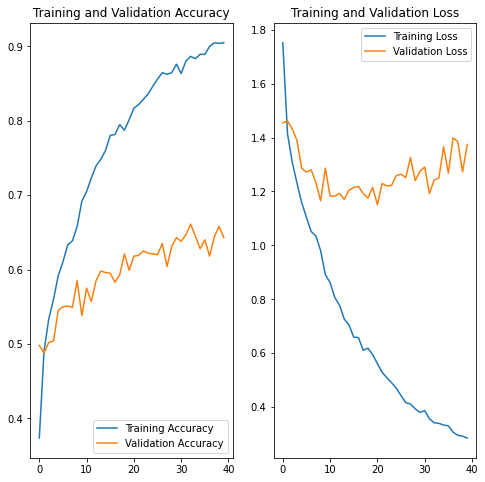

In [12]:
show_history(history)
# WE CAN SEE HERE THAT OUR MODEL LEARNING CORRECTLY.
# IT FEELS LIKE MODEL IS OVERFITTING APPROXIMATELY FROM EPOCH 20 BY LOOKING AT VALIDATION_LOSS INCREASING.

In [13]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)

50/50 [==============================] - 2s 24ms/step - loss: 1.4981 - accuracy: 0.6050


[1.4981074333190918, 0.6050000190734863]

In [18]:
BATCH_SIZE = 60
NUM_EPOCHS = 30
model, history = train(dataset)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 125, 128)          72704     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


/home/gmallet/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


134/134 [==============================] - 34s 220ms/step - loss: 1.7420 - accuracy: 0.3850 - val_loss: 1.5838 - val_accuracy: 0.4300
Epoch 2/30
134/134 [==============================] - 29s 217ms/step - loss: 1.4059 - accuracy: 0.4979 - val_loss: 1.4868 - val_accuracy: 0.4770
Epoch 3/30
134/134 [==============================] - 29s 215ms/step - loss: 1.3613 - accuracy: 0.5116 - val_loss: 1.4696 - val_accuracy: 0.4500
Epoch 4/30
134/134 [==============================] - 29s 218ms/step - loss: 1.2793 - accuracy: 0.5322 - val_loss: 1.2840 - val_accuracy: 0.5490
Epoch 5/30
134/134 [==============================] - 29s 217ms/step - loss: 1.1710 - accuracy: 0.5842 - val_loss: 1.2829 - val_accuracy: 0.5540
Epoch 6/30
134/134 [==============================] - 29s 220ms/step - loss: 1.1073 - accuracy: 0.6071 - val_loss: 1.3572 - val_accuracy: 0.5140
Epoch 7/30
134/134 [==============================] - 29s 216ms/step - loss: 1.0361 - accuracy: 0.6364 - val_loss: 1.3055 - val_accuracy: 0.5

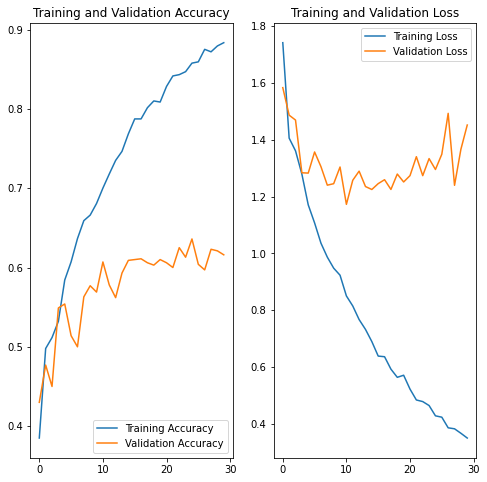

In [19]:
show_history(history)
# TAKE A LITTLE MORE TIME TO OVERFIT, BUT STILL DOES TOWARDS THE END.

In [22]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)

# ACCURACY IS NOT SO DIFFERENT, BUT ALREADY HAD +65% ON DIFFERENTS RUNS

50/50 [==============================] - 1s 21ms/step - loss: 1.5440 - accuracy: 0.6130


[1.543988823890686, 0.6129999756813049]

In [21]:
# SAVING MODEL
model.save("./models/rnn_gtzan_mfcc")

INFO:tensorflow:Assets written to: ./models/rnn_gtzan_mfcc/assets


INFO:tensorflow:Assets written to: ./models/rnn_gtzan_mfcc/assets
